In [28]:
import astropy.units as u
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt

In [88]:
fn = "/blue/adamginsburg/abulatek/brick/dasar/recleaning/brick_107GHz_dasar_line_1mJy_multiscale.image"
cube = SpectralCube.read(fn, use_dask=True).with_spectral_unit(u.GHz).to(u.K)
vmin = -20*u.km/u.s # I did -10 km/s originally
vmax = 25*u.km/u.s # I did 50 km/s and 70 km/s originally, then for mom0, I did 15 km/s
restf = 107.013831*u.GHz
scube = cube.with_spectral_unit(u.km/u.s, rest_value=restf, velocity_convention='radio').spectral_slab(vmin, vmax)

/blue/adamginsburg/abulatek/miniconda3/lib/python3.9/site-packages/casa_formats_io-0.0.0-py3.9-linux-x86_64.egg/casa_formats_io/casa_dask.py:232: RuntimeWarning: divide by zero encountered in long_scalars
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


In [89]:
# Continuum subtraction
med = scube.median(axis=0)  
scube_contsub = scube - med

In [90]:
min_map = scube_contsub.min(axis=0)

In [91]:
sigma = scube_contsub.mad_std().value
sigma

0.03355051989770885

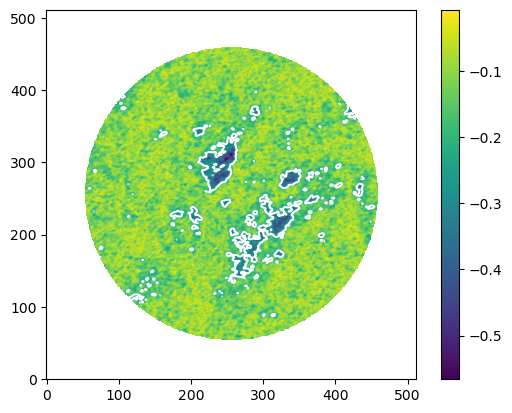

In [49]:
ax = plt.subplot(111,) 

im = ax.imshow(min_map.value, origin = 'lower')
ax.contour(min_map.value, levels = [-4*sigma], colors = 'w', linestyles = 'solid')
plt.colorbar(mappable = im)

In [69]:
# A very stupid way to do this, but it's a way
[m, n] = np.where(min_map < -4*sigma*u.K)
min_map_mask = np.zeros(min_map.shape)
min_map_masked =np.zeros(min_map.shape)
min_map_mask[m, n] = 1
min_map_masked[m, n] = min_map[m, n]

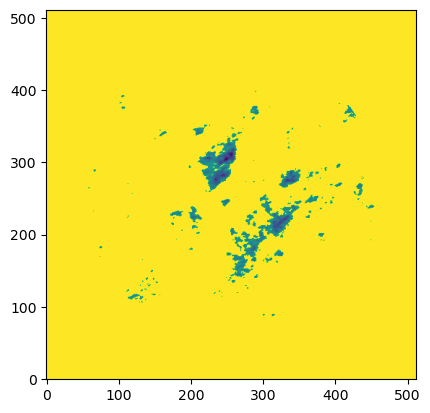

In [65]:
plt.imshow(min_map_masked, origin = 'lower')

In [66]:
import numpy as np
np.nanmin(min_map_masked)

-0.5659290570914135

In [67]:
np.nanmin(min_map)

<Projection -0.56592906 K>

In [68]:
# What is the uncertainty again? We need it for good rounding
sigma

0.06116435727151685

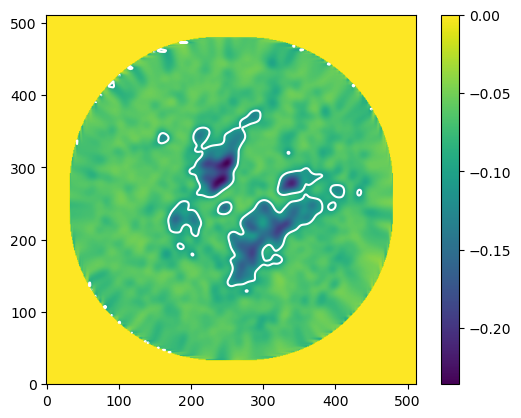

In [99]:
from astropy.convolution import convolve_fft, Gaussian2DKernel

min_map_smooth = convolve_fft(min_map, Gaussian2DKernel(5))

ax = plt.subplot(111,) 

im = ax.imshow(min_map_smooth.value, origin = 'lower')
ax.contour(min_map_smooth.value, levels = [-3*sigma], colors = 'w', linestyles = 'solid')
plt.colorbar(mappable = im)

In [102]:
# A very stupid way to do this, but it's a way
min_map_mask = min_map_smooth < -3*sigma*u.K

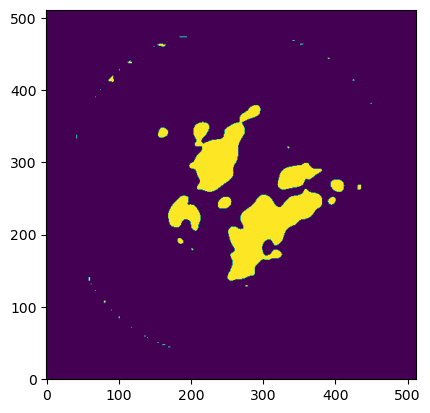

In [103]:
plt.imshow(min_map_mask, origin = 'lower')

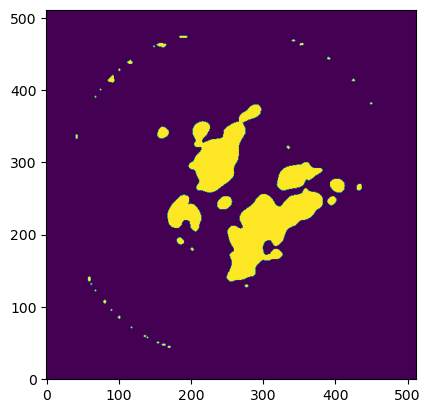

In [104]:
min_map_mask_d1 = scipy.ndimage.binary_dilation(min_map_mask, iterations = 1)
plt.imshow(min_map_mask_d1, origin = 'lower')

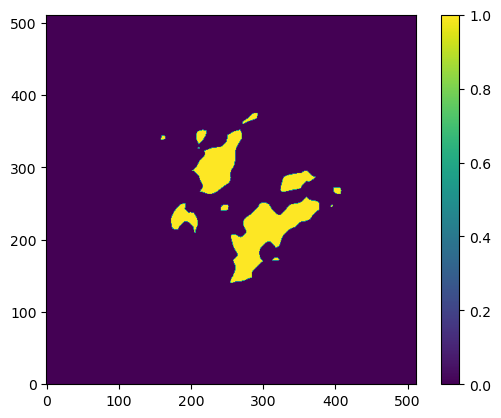

In [119]:
# Let's make the mask look better
import scipy.ndimage

min_map_mask_e = scipy.ndimage.binary_erosion(min_map_mask_d1, iterations = 5)
plt.imshow(min_map_mask_e, origin = 'lower')
plt.colorbar()

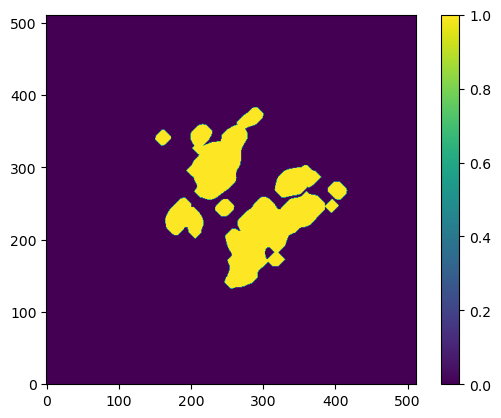

In [120]:
min_map_mask_e_d = scipy.ndimage.binary_dilation(min_map_mask_e, iterations = 8)
plt.imshow(min_map_mask_e_d, origin = 'lower')
plt.colorbar()

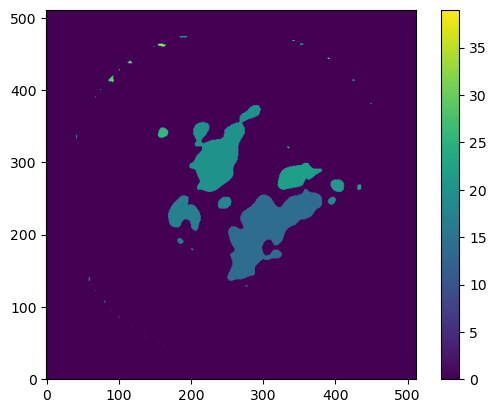

In [121]:
plt.imshow(scipy.ndimage.label(min_map_mask)[0], origin = 'lower')
plt.colorbar()

In [117]:
good = np.unique(scipy.ndimage.label(min_map_mask)[0][min_map_mask_e_d.astype('bool')])

array([ 0, 14, 17, 18, 19, 20, 21, 22, 26], dtype=int32)

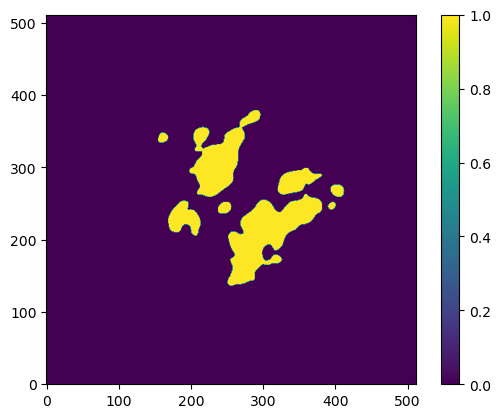

In [123]:
plt.imshow(np.isin(scipy.ndimage.label(min_map_mask)[0], good[1:]), origin = 'lower')
plt.colorbar()